In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
# import gensim
# from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hl100\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hl100\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hl100\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# data_dir = 'E:\Work_DatPT\Study\Master'
df_train = pd.read_csv('D:\Hoc\SecBert\SecBERT\multilabel-train\dataset_capec.csv')
# df_train = pd.read_csv('E:\Work_DatPT\Study\Master\SecBERT\multilabel-train\dataset_capec_multilabel.csv')
# df_train = df_train.head(300000)


<>:2: SyntaxWarning: invalid escape sequence '\H'
<>:2: SyntaxWarning: invalid escape sequence '\H'
C:\Users\hl100\AppData\Local\Temp\ipykernel_9548\3224321618.py:2: SyntaxWarning: invalid escape sequence '\H'
  df_train = pd.read_csv('D:\Hoc\SecBert\SecBERT\multilabel-train\dataset_capec.csv')


C:\Users\hl100\AppData\Local\Temp\ipykernel_9548\2464674673.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette=colors)


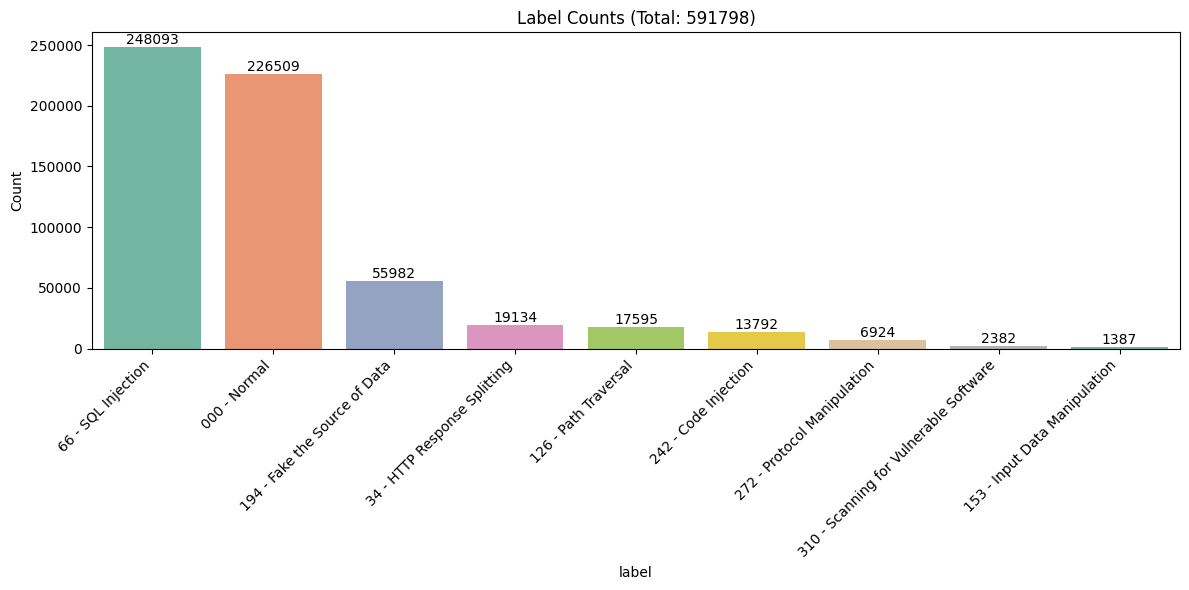

In [3]:
label_counts = df_train['label'].value_counts()

# Create a color palette for the bars
colors = sns.color_palette("Set2", len(label_counts))

# Create a bar chart with specified colors
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette=colors)

# Add labels to the bars
for i, (label, count) in enumerate(label_counts.items()):
    ax.text(i, count, str(count), ha='center', va='bottom')

# Customize the chart
total_count = label_counts.sum()
plt.title(f'Label Counts (Total: {total_count})')
plt.ylabel('Count')

# Rotate the x-axis labels for readability
plt.xticks(rotation=45, ha="right")

# Show the chart
plt.tight_layout()
plt.show()


In [22]:
label_counts = df_train.groupby('label').size().reset_index(name='count')

# Calculate the percentage of each group
total_count = label_counts['count'].sum()
label_counts['percentage'] = (label_counts['count'] / total_count) * 100

# Print the table
print(label_counts)

                                    label   count  percentage
0                            000 - Normal  226509   38.274715
1                    126 - Path Traversal   17595    2.973143
2           153 - Input Data Manipulation    1387    0.234371
3           194 - Fake the Source of Data   55982    9.459647
4                    242 - Code Injection   13792    2.330525
5             272 - Protocol Manipulation    6924    1.169994
6  310 - Scanning for Vulnerable Software    2382    0.402502
7            34 - HTTP Response Splitting   19134    3.233198
8                      66 - SQL Injection  248093   41.921906


In [4]:
df_train['text'] = df_train['text'].str.replace('/',' ')
# df_train.head(10)

#Lấy 100 giá trị đầu tiên cho mỗi nhãn
grouped_df = df_train.groupby('label').head(1)

grouped_df.head(100)

,text,label
0,GET blog index.php 2020 04 04 voluptatum-repr...,000 - Normal
2400,GET .svn entries,126 - Path Traversal
2528,GET blog wp-admin load-styles.php?c=0&dir=ltr...,66 - SQL Injection
2865,GET blog index.php my-account,272 - Protocol Manipulation
3910,GET nmaplowercheck1595007349,310 - Scanning for Vulnerable Software
6323,GET index.php?s= Index \x5Cthink\x5Capp invok...,242 - Code Injection
18168,POST blog index.php my-account edit-password ...,153 - Input Data Manipulation
42330,GET http%3A%2F%2Fwww.google.com%2F,194 - Fake the Source of Data
237122,GET blog%0Acat+%2Fetc%2Fpasswd%0A,34 - HTTP Response Splitting


In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import json


class Vectorizer:
    def __init__(self, method='BOW', ngram_range=(1, 1), max_features=300, emb_fname='', word_index_fname=''):
        self.method = method
        if self.method == 'BOW':
            self.vectorizer = CountVectorizer(analyzer='word', input='content', ngram_range=ngram_range, max_features=max_features)
        elif self.method == 'TFIDF':
            self.vectorizer = TfidfVectorizer(analyzer='word', input='content', max_features=max_features)
        elif self.method == 'Word2Vec':
            self.max_features = max_features
            self.emb_fname = emb_fname
            self.word_index_fname = word_index_fname
        else:
            raise ValueError('Feature extraction method does not exist.')

    def feature_extraction(self, X_train, X_test):
        train_data = self.vectorizer.fit_transform(X_train).toarray()
        test_data = self.vectorizer.transform(X_test).toarray()
        return train_data, test_data

    def get_word_index(self):
        word2id = json.load(open(self.word_index_fname, 'r'))
        return word2id

    def get_embedding_matrix(self):
        np.random.seed(0)
        word2id = self.get_word_index()
        embedding_matrix = np.random.uniform(-0.25, 0.25, [len(word2id) + 1, self.max_features])
        with open(self.emb_fname, 'r', encoding='utf-8') as f:
            for line in f:
                content = line.split(' ')
                if content[0] in word2id:
                    embedding_matrix[word2id[content[0]]] = np.array(list(map(float, content[1:])))
        return embedding_matrix

In [6]:
X_train, X_val, y_train, y_val = train_test_split(df_train["text"],
                                                  df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)
vectorizer = Vectorizer('TFIDF')
train_features, test_features = vectorizer.feature_extraction(X_train, X_val)
# Optional (not effect very much)
df_train['text'] = df_train['text'].str.replace('/',' ')
df_train.head()

,text,label
0,GET blog index.php 2020 04 04 voluptatum-repr...,000 - Normal
1,GET blog xmlrpc.php?rsd,000 - Normal
2,GET blog index.php 2020 04 04 nihil-tenetur-e...,000 - Normal
3,GET blog index.php 2020 04 04 explicabo-qui-f...,000 - Normal
4,GET blog index.php 2020 04 04 explicabo-qui-f...,000 - Normal


## Naive Bayes Classifier

In [17]:
from sklearn.naive_bayes import MultinomialNB
X_train, X_val, y_train, y_val = train_test_split(df_train["text"],
                                                  df_train["label"],
                                                  test_size=0.3,
                                                  shuffle=True)
vectorizer = Vectorizer('TFIDF')
train_features, test_features = vectorizer.feature_extraction(X_train, X_val)
mnb = MultinomialNB()
mnb.fit(train_features, y_train)
print(mnb.score(test_features, y_val))


0.867139799481807


In [18]:
y_predict = mnb.predict(test_features)
print(classification_report(y_val,y_predict, digits=4))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

c:\Users\hl100\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hl100\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hl100\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

                                        precision    recall  f1-score   support

                          000 - Normal     0.8065    0.9287    0.8633     67789
                  126 - Path Traversal     0.9950    0.7920    0.8819      5292
         153 - Input Data Manipulation     0.0991    1.0000    0.1804       402
         194 - Fake the Source of Data     0.9799    0.9093    0.9433     16652
                  242 - Code Injection     0.9720    0.9137    0.9419      4136
           272 - Protocol Manipulation     0.0000    0.0000    0.0000      2059
310 - Scanning for Vulnerable Software     0.9437    0.3007    0.4561       725
          34 - HTTP Response Splitting     0.9542    0.9176    0.9356      5681
                    66 - SQL Injection     0.9377    0.8295    0.8803     74804

                              accuracy                         0.8671    177540
                             macro avg     0.7431    0.7324    0.6759    177540
                          weighted avg

## Random Forest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, criterion='gini')
rf.fit(train_features, y_train)
print(rf.score(test_features, y_val))

0.9585276557395517


In [20]:
y_predict = rf.predict(test_features)
print(classification_report(y_val,y_predict, digits=4))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal     0.9202    0.9916    0.9546     67789
                  126 - Path Traversal     0.9990    0.9210    0.9584      5292
         153 - Input Data Manipulation     0.2667    0.1493    0.1914       402
         194 - Fake the Source of Data     0.9975    0.9295    0.9623     16652
                  242 - Code Injection     0.9976    0.9915    0.9945      4136
           272 - Protocol Manipulation     0.6239    0.1442    0.2343      2059
310 - Scanning for Vulnerable Software     0.8831    0.9793    0.9287       725
          34 - HTTP Response Splitting     1.0000    1.0000    1.0000      5681
                    66 - SQL Injection     0.9857    0.9592    0.9723     74804

                              accuracy                         0.9585    177540
                             macro avg     0.8526    0.7851    0.7996    177540
                          weighted avg

## DecisionTreeClassifier

In [21]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini')
dt.fit(train_features, y_train)
y_predict = dt.predict(test_features)
print(classification_report(y_val,y_predict, digits=4))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal     0.9202    0.9921    0.9548     67789
                  126 - Path Traversal     0.9982    0.9212    0.9581      5292
         153 - Input Data Manipulation     0.2683    0.0547    0.0909       402
         194 - Fake the Source of Data     0.9984    0.9283    0.9621     16652
                  242 - Code Injection     0.9961    0.9937    0.9949      4136
           272 - Protocol Manipulation     0.5941    0.1564    0.2476      2059
310 - Scanning for Vulnerable Software     0.8846    0.9724    0.9264       725
          34 - HTTP Response Splitting     1.0000    1.0000    1.0000      5681
                    66 - SQL Injection     0.9854    0.9598    0.9724     74804

                              accuracy                         0.9588    177540
                             macro avg     0.8495    0.7754    0.7897    177540
                          weighted avg

In [13]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from transformers import TrainingArguments, Trainer
# import numpy as np
# from datasets import Dataset

# df = pd.read_csv('E:\Work_DatPT\Study\Master\SecBERT\multilabel-train\dataset_capec_multilabel.csv')

# # Chuyển đổi nhãn thành số
# label_dict = {value: idx for idx, value in enumerate(df['label'].unique())}
# df['label'] = df['label'].map(label_dict)
# # Chia dữ liệu
# X_train, X_test, y_train, y_test = train_test_split(df['httprequest'], df['label'], test_size=0.2)

# # Tải tokenizer và mô hình
# model_name = "jackaduma/SecBERT"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_dict))

# # Tiền xử lý và mã hóa dữ liệu
# def tokenize_function(examples):
#     return tokenizer(examples, padding="max_length", truncation=True, max_length=512)

# train_encodings = tokenize_function(X_train.tolist())
# test_encodings = tokenize_function(X_test.tolist())

# # Giả sử `train_encodings` và `test_encodings` là kết quả của việc mã hóa dữ liệu văn bản của bạn
# train_dataset = Dataset.from_dict({
#     'input_ids': train_encodings['input_ids'],
#     'attention_mask': train_encodings['attention_mask'],
#     'labels': y_train
# })

# test_dataset = Dataset.from_dict({
#     'input_ids': test_encodings['input_ids'],
#     'attention_mask': test_encodings['attention_mask'],
#     'labels': y_test
# })

# # Thiết lập các tham số huấn luyện
# training_args = TrainingArguments(
#     output_dir="./results",                # thư mục để lưu kết quả và checkpoints
#     num_train_epochs=3,                    # tổng số epochs huấn luyện
#     per_device_train_batch_size=4,         # kích thước batch khi huấn luyện
#     per_device_eval_batch_size=4,          # kích thước batch khi đánh giá
#     warmup_steps=500,                      # số bước warmup
#     weight_decay=0.01,                     # weight decay để tránh overfitting
#     evaluation_strategy="epoch",           # đánh giá sau mỗi epoch
#     logging_dir='./logs',                  # thư mục để lưu logs
#     logging_steps=10,                      # log metric sau mỗi 10 bước
# )

# # Khởi tạo Trainer với mô hình và các tham số huấn luyện đã thiết lập
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
# )

# trainer.train()

# # Đánh giá mô hình
# predictions = trainer.predict(test_dataset)
# preds = np.argmax(predictions.predictions, axis=-1)

# # Tính toán và in ra f1 score, precision, và accuracy
# print(classification_report(y_test, preds, target_names=label_dict.keys()))


In [14]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# import pandas as pd
# from sklearn.metrics import classification_report
# from sklearn.preprocessing import LabelEncoder
# import torch
# import numpy as np
# # Initialize tokenizer and model
# model_name = "jackaduma/SecBERT"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name)
# # Convert to DataFrame
# # df = pd.read_csv('E:\Work_DatPT\Study\Master\SecBERT\multilabel-train\dataset_capec_multilabel_all.csv')
# # df = pd.DataFrame(data)
# df_base = pd.read_csv('D:\Hoc\SecBert\SecBERT\\multilabel-train\dataset_capec_multiclass.csv').head(4000);
# # Lấy 100 giá trị đầu tiên cho mỗi nhãn
# # grouped_df = df_base.groupby('label').head(400)

# # Chuyển grouped_df thành DataFrame
# # df = pd.DataFrame(df_base[['httprequest', 'label']])
# df = df_base;
# print(df.head(10))
# # label_counts = df['label'].value_counts()
# # print("Số lượng dòng theo label:")
# # print(label_counts)
# # # Encode labels
# label_encoder = LabelEncoder()
# df['encoded_labels'] = label_encoder.fit_transform(df['label'])

# # Tokenize http requests
# tokens = tokenizer(df['httprequest'].tolist(), padding=True, truncation=True, return_tensors="pt")

# # Predict
# model.eval()  # Put model in evaluation mode
# with torch.no_grad():
#     outputs = model(**tokens)
#     predictions = torch.argmax(outputs.logits, dim=-1)

# # Get the true labels and predicted labels
# true_labels = df['encoded_labels'].tolist()
# predicted_labels = predictions.numpy().tolist()
# # Extract the labels parameter which should contain all unique label IDs
# labels = df['encoded_labels'].unique()

# # Make sure that the labels parameter is sorted since classification_report expects labels to be sorted
# labels = np.sort(labels)
# # Get classification report
# report = classification_report(true_labels, predicted_labels, labels=labels, target_names=label_encoder.inverse_transform(labels))
# print(report)


In [15]:
# import pandas as pd

# # Đọc dữ liệu từ file CSV
# df = pd.read_csv('E:\\Work_DatPT\\Study\\Master\\SecBERT\\multilabel-train\\dataset_capec_multilabel_all.csv')

# # Lấy 100 giá trị đầu tiên cho mỗi nhãn
# grouped_df = df.groupby('label').head(100)

# # Chuyển grouped_df thành DataFrame
# merged_df = pd.DataFrame(grouped_df[['httprequest', 'label']])



In [16]:
# configuration for training, you should modify these values to get the best performance
config = {
    "num_labels": 8,
    "hidden_dropout_prob": 0.15,
    "hidden_size": 768,
    "max_length": 512,
}

training_parameters = {
    "batch_size": 32,
    "epochs": 10,
    "output_folder": "/colab/working",
    "output_file": "model.bin",
    "learning_rate": 2e-5,
    "print_after_steps": 100,
    "save_steps": 5000,

}
predicted_labels_dict = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0
    }

attack_dict = {
    '000 - Normal': 0,
    '126 - Path Traversal': 1,
    '242 - Code Injection': 2,
    '153 - Input Data Manipulation': 3,
    '310 - Scanning for Vulnerable Software': 4,
    '194 - Fake the Source of Data': 5,
    '34 - HTTP Response Splitting': 6,
    '66 - SQL Injection':7,
    '272 - Protocol Manipulation':8
            }